In [1]:
from sbi_feature_importance.experiment_helper import SimpleDB
from sbi_feature_importance.utils import skip_dims, sort_by_missing_dims
from sbi_feature_importance.analysis import plot_iqrchanges, plot_vtrace_comparison

from ephys_helper.hh_simulator import HHSimulator

import torch
import matplotlib.pyplot as plt

from sbi.analysis import pairplot
import matplotlib as mpl
from sbi_feature_importance.analysis import add_scalebar
import pandas as pd
import seaborn as sns

import time
import IPython.display as IPd
from svgutils.compose import *

In [2]:
results_db = SimpleDB("../results/fig3", "r")
data_db = SimpleDB("../results/HH1M", "r")

WARNING    /home/jnsbck/Uni/PhD/projects/publish_mscthesis/code/sbi_feature_importance/experiment_helper.py:233: UserWarning: Directory already exists
  warnings.warn("Directory already exists")
 [py.warnings]


In [3]:
all_dims = list(range(10))
dims = [all_dims] + skip_dims(all_dims)
features = [0,1,2,3,8,13,18,19,21,22]
hh = HHSimulator()
hh.set_static_parameters(new_model_params=data_db.query("model_parameters"))
prior = data_db.query("prior")
limits = torch.stack([prior.base_prior.base_dist.low, prior.base_prior.base_dist.high]).T

In [4]:
maf_results_db = SimpleDB("../results4revision/fig3", "r")
direct_tag = f"direct_maf_mcmc_9_"
direct_maf_samples = maf_results_db.find(direct_tag)

labels, data = sort_by_missing_dims(direct_maf_samples, features)
default_maf_base_sample = data[labels == -1].squeeze()
default_maf_data = data[labels != -1]

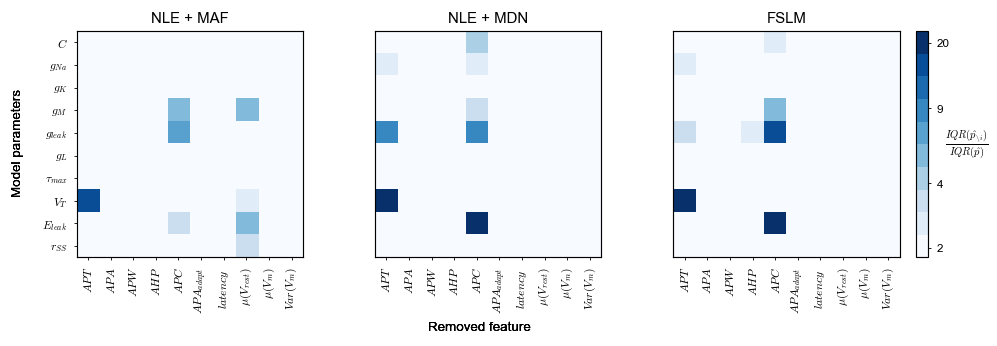

In [320]:
loss = "experimental"
sampling_method = "mcmc"
params = "1_1_00"

direct_tag = f"direct_default_{sampling_method}_0_"
direct_samples = results_db.find(direct_tag)

labels, data = sort_by_missing_dims(direct_samples, features)
default_base_sample = data[labels == -1].squeeze()
default_data = data[labels != -1]

posthoc_tag = f"posthoc_{loss}_{sampling_method}_2_{params}"
posthoc_samples = results_db.find(posthoc_tag)
labels, data = sort_by_missing_dims(posthoc_samples, features)
posthoc_base_sample = data[labels == -1].squeeze()
posthoc_data = data[labels != -1]

fts_labels = [val for key, val in hh.features().items() if int(key) in features]
fts_labels[6] += "  " # fixes latency colliding with xticks

with mpl.rc_context(fname=".mpl_rc"):
    fig, axes = plt.subplots(1,3, sharey=True, figsize=(12,2.45))
    for ax, data, base_sample in zip(axes, [default_maf_data, default_data, posthoc_data], [default_maf_base_sample, default_base_sample, posthoc_base_sample]):
        active_ax = plt.axes(ax)
        im = plot_iqrchanges(data, base_sample, zlims=[2,20], add_cbar=False, agg_with="median")
        active_ax.set_xticks(range(10))
        active_ax.set_yticks(range(10))
        active_ax.set_yticklabels(list(hh.parameters(include_units=False).keys()))
        active_ax.set_xticklabels(fts_labels, rotation=90)
        active_ax.tick_params(axis="both", which="major")
        axes[1].tick_params(axis="y", which="both", size=0)
        axes[2].tick_params(axis="y", which="both", size=0)
        fig.text(0.48, -0.13, "Removed feature", ha="center", va="center")
        yticktype = type(ax.get_yticks()[0])
        fig.text(
            0.16,
            0.5,
            "Model parameters",
            ha="center",
            va="center",
            rotation=90,
        )
        active_ax.spines['right'].set_visible(True)
        active_ax.spines['top'].set_visible(True)

    plt.subplots_adjust(wspace=-0.11, hspace=-0.3)
    axes[0].set_title("NLE + MAF", size=9, pad=5)
    axes[1].set_title("NLE + MDN", size=9, pad=5)
    axes[2].set_title("FSLM", size=9, pad=5)

    cbar = fig.colorbar(im, ax=axes.ravel().tolist(),pad=0.015)
    cbar.ax.get_yaxis().labelpad = 10
    cbar.set_label(r"$\frac{IQR(\hat{p}_{\backslash i})}{IQR(\hat{p})}$", rotation=0, ha="center", va="center", size=9)
    vmin, vmax = im.get_clim()

    cticks = (
        torch.logspace(
            torch.log10(torch.tensor(vmin)), torch.log10(torch.tensor(vmax)), 4
        )
        .int()
        .numpy()
    )
    cbar.set_ticks(cticks+[0.2,0.25,0.1,-2.2])
    cbar.set_ticklabels(cticks)
    cbar.ax.minorticks_off()
    plt.savefig("../paper/fig3/svg/panel_a.svg")

plt.show()

In [6]:
model_params = data_db.query("model_parameters")
stimulus = data_db.query("stimulus_protocol")
hh = HHSimulator()
hh.set_static_parameters(model_params)
hh.set_stimulus(protocol_params=stimulus)


theta_o = data_db.query("theta_o")
t_o, Vt_o, It_o =  hh.simulate(theta_o, -70, stimulus_noise=0)
x_o = hh.summarise(t_o, Vt_o,It_o)

batch size was automatically set to 1.


Running 1 tasks with 1 batches per worker.:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
thetas_full = results_db.query("posthoc_experimental_mcmc_2_1_1_00_[0, 1, 2, 3, 8, 18, 19, 21, 22]")
thetas_no_APT = results_db.query("posthoc_experimental_mcmc_2_1_1_00_[1, 2, 3, 8, 13, 18, 19, 21, 22]")
thetas_no_APA = results_db.query("posthoc_experimental_mcmc_2_1_1_00_[0, 2, 3, 8, 13, 18, 19, 21, 22]")
ts_full, Vts_full, Its_full = hh.simulate(thetas_full[:100], -70, stimulus_noise=0)
ts_no_APT, Vts_no_APT, Its_no_APT = hh.simulate(thetas_no_APT[:100], -70, stimulus_noise=0)
ts_no_APA, Vts_no_APA, Its_no_APA = hh.simulate(thetas_no_APA[:100], -70, stimulus_noise=0)

batch size was automatically set to 25.


Running 100 tasks with 4 batches per worker.:   0%|          | 0/4 [00:00<?, ?it/s]

batch size was automatically set to 25.


Running 100 tasks with 4 batches per worker.:   0%|          | 0/4 [00:00<?, ?it/s]

batch size was automatically set to 25.


Running 100 tasks with 4 batches per worker.:   0%|          | 0/4 [00:00<?, ?it/s]

WARNING    /tmp/ipykernel_197125/2625263825.py:27: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("../paper/fig3/svg/panel_b.svg")
 [py.warnings]


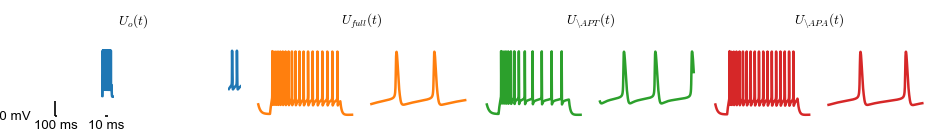

In [313]:
with mpl.rc_context(fname=".mpl_rc"):
    ts = torch.vstack([t_o, ts_full[0], ts_no_APT[49], ts_no_APA[0]])
    Vts = torch.vstack([Vt_o, Vts_full[0], Vts_no_APT[49], Vts_no_APA[0]])
    

    fig = plt.figure(figsize=(7.6,0.9), constrained_layout=True)
    subfigs = fig.subfigures(nrows=1, ncols=4, wspace=0.01, hspace=0)
    axes = [subfig.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.0}, sharey=True) for subfig in subfigs.ravel()]

    labels = [r"$U_o(t)$", r"$U_{full}(t)$", r"$U_{\backslash APT}(t)$", r"$U_{\backslash APA}(t)$"]
    for i, (label, color) in enumerate(zip(labels, ["tab:blue", "tab:orange", "tab:green", "tab:red"])):
        axes[i][0].plot(ts[i].numpy(),Vts[i].numpy(), color=color)
        subfigs[i].suptitle(label, rotation=0, size=8, verticalalignment="center")
        axes[i][0].spines['left'].set_visible(False)
        axes[i][0].spines['bottom'].set_visible(False)
        axes[i][0].tick_params(axis="both", which="both", size=0)
        axes[i][0].set_xticks([])
        axes[i][0].set_yticks([])
        axes[i][1].plot(ts[i, 3100:4100].numpy(),Vts[i, 3100:4100].numpy(), color=color)
        axes[i][1].spines['left'].set_visible(False)
        axes[i][1].spines['bottom'].set_visible(False)
        axes[i][1].tick_params(axis="both", which="both", size=0)
        axes[i][1].set_xticks([])
        axes[i][1].set_yticks([])
    add_scalebar(axes[0][0], loc="lower left", barwidth=1, labely=f"{50} mV", labelx=f"{100} ms", sizex=100, sizey=50, matchx=False, matchy=False, pad=0.0, borderpad=0, bbox_to_anchor=(-8, 2),hidey=False)
    add_scalebar(axes[0][1],loc="lower left", barwidth=1, labelx=f"{10} ms", labely=None, sizex=10, sizey=0, matchx=False, matchy=False, pad=0, borderpad=0, bbox_to_anchor=(88, 2))
    plt.savefig("../paper/fig3/svg/panel_b.svg")
plt.show()

In [28]:
# from ephys_helper.analysis import plot_vtrace
# theta_0 = thetas_no_APT[49].clone().repeat(10,1)
# theta_0[:,7] = torch.linspace(limits[3][0],limits[3][1],10)
# ts_0, Vts_0, Its_0 = hh.simulate(theta_0, -70, stimulus_noise=0)

# for t,V in zip(ts_0, Vts_0):
#     plot_vtrace(t.view(1,-1), V.view(1,-1))
#     plt.show()

In [9]:
x_full = hh.simulate_and_summarise(thetas_full[:1000], -70, stimulus_noise=0, n_workers=4, batch_size=50)
x_no_APT = hh.simulate_and_summarise(thetas_no_APT[:1000], -70, stimulus_noise=0, n_workers=4, batch_size=50)
x_no_APA = hh.simulate_and_summarise(thetas_no_APA[:1000], -70, stimulus_noise=0, n_workers=4, batch_size=50)

Running 1000 tasks with 20 batches per worker.:   0%|          | 0/20 [00:00<?, ?it/s]

Running 1000 tasks with 20 batches per worker.:   0%|          | 0/20 [00:00<?, ?it/s]

Running 1000 tasks with 20 batches per worker.:   0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
xs = torch.vstack([x_full[:,features], x_no_APT[:,features], x_no_APA[:,features]]).view(-1).numpy()
labels = ["Full"]*1000*10 + ["No APT"]*1000*10 + ["No APA"]*1000*10
fts = [f"{x-0.1}" for x in features]*1000 + [f"{x}" for x in features]*1000 + [f"{x+0.1}" for x in features]*1000
df = pd.DataFrame({"Samples":xs, "Posterior":labels, "Features":fts})

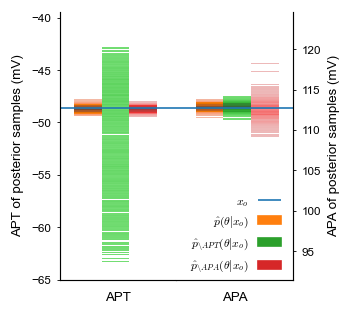

In [76]:
with mpl.rc_context(fname=".mpl_rc"):
    sns.set_style(rc=mpl.rc_params_from_file(".mpl_rc"))
    fig, ax = plt.subplots(1,2,figsize=(2.5,2.9))
    active_ax = plt.axes(ax[0])
    sns.histplot(ax=ax[0], data=df[df["Features"].isin(["-0.1", "0", "0.1"])], x="Features", y="Samples", hue="Posterior", palette=["tab:orange", "tab:green", "tab:red"],legend=False, binwidth=0.1)
    ax[0].set_xlabel("APT")
    ax[0].set_ylabel("APT of posterior samples (mV)")
    ax[0].set_xticklabels([])
    ax[0].tick_params(axis="x", which="both", size=0)

    active_ax = plt.axes(ax[1])
    sns.histplot(ax=ax[1], data=df[df["Features"].isin(["0.9", "1", "1.1"])], x="Features", y="Samples", hue="Posterior", palette=["tab:orange", "tab:green", "tab:red"], binwidth=0.1)
    ax[1].set_xlabel("APA")
    ax[1].set_ylabel("APA of posterior samples (mV)")
    ax[1].set_xticklabels([])
    ax[1].tick_params(axis="x", which="both", size=0)
    ax[0].hlines(xmin=-3,xmax=5,y=x_o[:, features][:,0].view(-1).numpy(), colors="tab:blue",label=r"$x_o$", ls="solid", alpha=1, lw=1)
    p = ax[1].hlines(xmin=-3,xmax=5,y=x_o[:, features][:,1].view(-1).numpy(), colors="tab:blue",label=r"$x_o$", ls="solid", alpha=1, lw=1)
    ax[1].legend(handles=[p] + ax[1].legend_.legendHandles, labels=[r"$x_o$"]+[r" $ \hat{p}(\theta|x_o)}$",r" $ \hat{p}_{\backslash APT}(\theta|x_o)$",r" $ \hat{p}_{\backslash APA}(\theta|x_o)$"],
          title=None,
          bbox_to_anchor=(-0.0, 0.35), loc='upper left', fontsize=7, markerfirst=False)
    ax[1].yaxis.set_label_position("right")
    ax[1].yaxis.tick_right()
    ax[1].spines['right'].set_visible(True)
    ax[1].spines['left'].set_visible(False)
    ax[1].set_ylim(91.5,124.65)
    ax[0].set_ylim(-65,-39.4)
    ax[0].set_xlim(-1,3.2)
    ax[1].set_xlim(-1.2,3)
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.savefig("../paper/fig3/svg/panel_e.svg")

In [55]:
all_dims = list(range(10))
dims = [all_dims] + skip_dims(all_dims)[:4]
hh = HHSimulator()
hh.set_static_parameters(new_model_params=data_db.query("model_parameters"))
prior = data_db.query("prior")
theta_o = data_db.query("theta_o")

limits = torch.stack([prior.base_prior.base_dist.low, prior.base_prior.base_dist.high]).T
params = list(hh.parameters(include_units=False).keys())

subset = [0,1,4,7]
params = [p for i,p in enumerate(params) if i in subset]
limits = limits[subset]

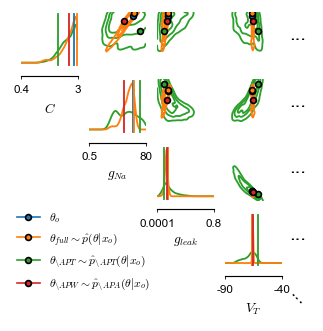

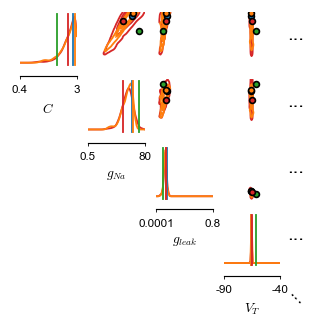

In [74]:
marker_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
points = [theta_o[:,subset], thetas_full[0, subset], thetas_no_APT[49, subset], thetas_no_APA[41, subset]]

with mpl.rc_context(fname=".mpl_rc"):
    fig, axes = pairplot([thetas_no_APT[:,subset],thetas_full[:,subset]], 
    figsize=(2.8,2.7), diag="kde", limits = limits, 
    labels=params, ticks=limits, points=points, upper="contour", 
    contour_offdiag= {'levels': [0.01,0.1,0.3], 'percentile': False, "lw":1}, 
    points_colors=marker_colors, 
    points_offdiag={"markersize": 3.5, "mew": 1, "marker": "o", "lw": 1, "alpha":1, "markeredgecolor":"k"},
    points_diag={"lw": 1.1, "alpha":1, "ls":"solid"},
    )
    
    blueto = "tab:green"
    orangeto = "tab:orange"
    greento = "tab:red"
    redto = "tab:blue"
    colors = {"#1f77b4":blueto, "#ff7f0e":orangeto, "#2ca02c":greento, "#d62728":redto, "black":"black", "tab:blue":blueto,"tab:orange":orangeto,"tab:green":greento,"tab:red":redto}
    for i, axe in enumerate(axes):
        for j, ax in enumerate(axe):
            for color, line in zip(colors, ax.collections):
                line.set_edgecolor(colors['#%02x%02x%02x' %tuple((line.get_edgecolors()[0,:3]*255).astype(int))])
                line.set_linewidth(1.1)
            for color, line in zip(colors, ax.lines):
                if line.get_color() in marker_colors:
                    pass
                else:
                    line.set_color(colors[line.get_color()])
                    line.set_linewidth(1.1)
            x0, x1 = ax.get_xlim()
            y0, y1 = ax.get_ylim()
            text_kwargs = {"fontsize": plt.rcParams["font.size"] * 1.5}
            if j == 3:
                ax.text(x1 + (x1 - x0) / 8.0, (y0 + y1) / 2.0, "...", **text_kwargs)
            if (i,j) == (3,3):
                ax.text(x1 + (x1 - x0) / 12.0, y0 - (y1 - y0) / 1.5, "...", rotation=-45, **text_kwargs)
    fig.legend(handles=[line for line in axes[0,1].lines if line.get_color() in marker_colors], labels=[r"$\theta_o$", r"$\theta_{full} \sim \hat{p}(\theta|x_o)$", r"$\theta_{\backslash APT} \sim \hat{p}_{\backslash APT}(\theta|x_o)$", r"$\theta_{\backslash APW} \sim \hat{p}_{\backslash APA}(\theta|x_o)$"], loc=3, bbox_to_anchor=(0.08,0.0))
    plt.savefig("../paper/fig3/svg/panel_c.svg")
plt.show()

with mpl.rc_context(fname=".mpl_rc"):
    fig, axes = pairplot([thetas_no_APA[:,subset],thetas_full[:,subset]], 
    figsize=(2.8,2.7), diag="kde", limits = limits, labels=params, 
    ticks=limits, points=points, upper="contour", 
    contour_offdiag= {'levels': [0.01,0.1,0.3], 'percentile': False}, 
    points_colors=marker_colors, 
    points_offdiag={"markersize": 3.5, "mew": 1, "marker": "o", "lw": 1, "alpha":1, "markeredgecolor":"k"},
    points_diag={"lw": 1.1, "alpha":1, "ls":"solid"},
    )

    blueto = "tab:red"
    orangeto = "tab:orange"
    greento = "tab:red"
    redto = "tab:blue"
    colors = {"#1f77b4":blueto, "#ff7f0e":orangeto, "#2ca02c":greento, "#d62728":redto, "black":"black", "tab:blue":blueto,"tab:orange":orangeto,"tab:green":greento,"tab:red":redto}

    for i, axe in enumerate(axes):
        for j, ax in enumerate(axe):
            for color, line in zip(colors, ax.collections):
                line.set_edgecolor(colors['#%02x%02x%02x' %tuple((line.get_edgecolors()[0,:3]*255).astype(int))])
                line.set_linewidth(1.1)
            for color, line in zip(colors, ax.lines):
                if line.get_color() in marker_colors:
                    pass
                else:
                    line.set_color(colors[line.get_color()])
                    line.set_linewidth(1.1)
            x0, x1 = ax.get_xlim()
            y0, y1 = ax.get_ylim()
            text_kwargs = {"fontsize": plt.rcParams["font.size"] * 1.5}
            if j == 3:
                ax.text(x1 + (x1 - x0) / 8.0, (y0 + y1) / 2.0, "...", **text_kwargs)
            if (i,j) == (3,3):
                ax.text(x1 + (x1 - x0) / 12.0, y0 - (y1 - y0) / 1.5, "...", rotation=-45, **text_kwargs)       
    # fig.legend(handles=[line for line in axes[0,1].lines if line.get_color() in marker_colors], labels=[r"$\theta_o$", r"$\theta_{full} \sim p(\theta_{full}|x_o)$", r"$\theta_{\backslash APT} \sim p(\theta_{\backslash APT}|x_o)$", r"$\theta_{\backslash APW} \sim p(\theta_{\backslash APW}|x_o)$"], loc=3, bbox_to_anchor=(0.08,-0.05))
    plt.savefig("../paper/fig3/svg/panel_d.svg")
plt.show()

In [330]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("20.3cm", "16.8cm",
           
Panel(
        SVG("../paper/fig3/svg/panel_a.svg").scale(svg_scale),
        Text("a", -10, 17.0, **kwargs_text),
).move(15, 5),

Panel(
        SVG("../paper/fig3/svg/panel_b.svg").scale(svg_scale),
        Text("b", -30, 15.0, **kwargs_text),
).move(35, 265),

Panel(
        SVG("../paper/fig3/svg/panel_c.svg").scale(svg_scale),
        Text("c", -5, 2.0, **kwargs_text),
).move(10, 390),

Panel(
        SVG("../paper/fig3/svg/panel_d.svg").scale(svg_scale),
        Text("d", -5, 2.0, **kwargs_text),
).move(245, 390),

Panel(
        SVG("../paper/fig3/svg/panel_e.svg").scale(svg_scale),
        Text("e", -20, 2.0, **kwargs_text),
).move(490, 390),
)

!mkdir -p fig
f.save("../paper/fig3/svg/fig.svg")
svg("../paper/fig3/svg/fig.svg")